In [27]:
# importing the libraries
import pandas as pd
import numpy as np
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD




from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms
import torch
import pickle

In [28]:
cuda0 = torch.device('cuda:0')


In [29]:
batch_size = 32

In [30]:
dataset = CIFAR10(root='data', download=True)

Files already downloaded and verified


In [31]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [32]:
transform = transforms.Compose([
   transforms.RandomHorizontalFlip(),
   transforms.ColorJitter(0.1,0.1,0.1,0.1),
   transforms.RandomRotation(20),
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
torch.manual_seed(43)
val_size = 5000
from torch.utils.data import random_split
train_size = len(trainset) - val_size

trainset, valset = random_split(trainset, [train_size, val_size])
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [34]:

len(trainset)


45000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
images.shape: torch.Size([32, 3, 32, 32])


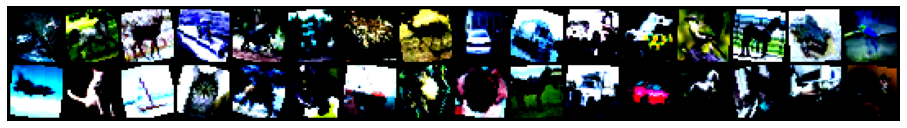

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


for images, _ in trainloader:
    print(type(images))
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break


In [36]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer #1
            Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer #2
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
             # Defining another 2D convolution layer #3
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
             # Defining another 2D convolution layer #4
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.1)
        )

        self.linear_layers = Sequential(
            Linear(128 * 2 * 2, 64),
            ReLU(inplace=True),
            Dropout(0.1),
            Linear(64, 32),
            ReLU(inplace=True),
            Dropout(0.1),
            Linear(32, 10),
            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [40]:
# defining the model
model = Net()
model = model.to(cuda0)
# defining the optimizer
optimizer = SGD(model.parameters(), lr=0.001,momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()

In [41]:
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [42]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [49]:
losses = []
losses_val = []
accuracy = []
accuracy_val = []
#min_loss = 0.2
#min_loss_val = 0.2
#max_acc = 0.7
#max_acc_val = 0.7
for epoch in range(200):  # loop over the dataset multiple times
    print('epoch: ',epoch)
    correct_v = 0.0
    loss_epoch_val = 0.0
    correct = 0.0
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum().item()
    with torch.no_grad():
      loss_epoch = running_loss / train_size
      losses.append(loss_epoch)
      acc_epoch = correct / train_size
      accuracy.append(acc_epoch)
      print('train loss: ', loss_epoch)
      print('train acc: ', acc_epoch)

    #Evaluate on validation set
    for i_batch, (x,y) in enumerate(valloader):
        with torch.no_grad():
            model.eval()
            x,y = x.to(cuda0), y.to(cuda0)
            outputs = model(x)
            loss = criterion(outputs, y)
            loss_epoch_val += loss

            _, predicted = torch.max(outputs.data, 1)
            correct_v += (predicted == y).sum().item()

    loss_epoch_val /= val_size
    acc_epoch_val = correct_v / val_size
    losses_val.append(loss_epoch_val)
    accuracy_val.append(acc_epoch_val)

    scheduler.step(loss_epoch_val)

    print('val loss: ', loss_epoch_val)
    print('val acc: ', acc_epoch_val)


print('Finished Training')

epoch:  0
train loss:  0.01962927466299799
train acc:  0.7843333333333333
val loss:  tensor(0.0215, device='cuda:0')
val acc:  0.7604
epoch:  1
train loss:  0.019582378051347202
train acc:  0.7830888888888888
val loss:  tensor(0.0214, device='cuda:0')
val acc:  0.763
epoch:  2
train loss:  0.019323776879575517
train acc:  0.7864888888888889
val loss:  tensor(0.0211, device='cuda:0')
val acc:  0.7704
epoch:  3
train loss:  0.019407832501994238
train acc:  0.7864
val loss:  tensor(0.0215, device='cuda:0')
val acc:  0.7608
epoch:  4
train loss:  0.01938225736816724
train acc:  0.7868222222222222
val loss:  tensor(0.0216, device='cuda:0')
val acc:  0.7622
epoch:  5
train loss:  0.019277236062288285
train acc:  0.7868
val loss:  tensor(0.0212, device='cuda:0')
val acc:  0.768
epoch:  6
train loss:  0.01911167819665538
train acc:  0.7927555555555555
val loss:  tensor(0.0211, device='cuda:0')
val acc:  0.7648
epoch:  7
train loss:  0.01900161046932141
train acc:  0.7917333333333333
val loss: 

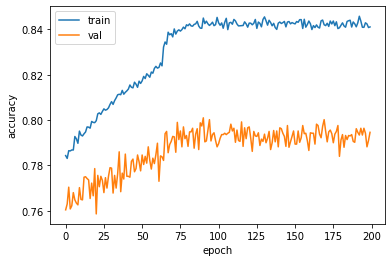

In [50]:
#plt.title('Train accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(200)),accuracy, label='train')
plt.plot(list(range(200)),accuracy_val, label='val')
plt.legend(loc="upper left")
# plt.savefig('transforms_p2.jpg')

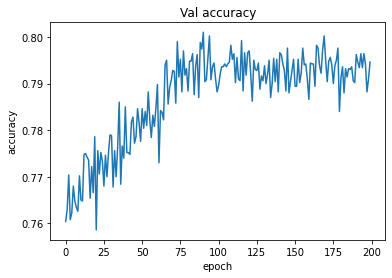

In [51]:
plt.title('Val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accuracy_val)

In [52]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 train images: 87 %


In [53]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %
